In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

train_data = pd.read_parquet("/content/drive/MyDrive/TP2 - ORGANIZACIÓN DE DATOS/dataset_v2/train.parq", engine="pyarrow")

#https://colab.research.google.com/drive/1M9Hh3YWE5jiA59oerCf6fChVYaFJq3Gp?usp=sharing
one_hot_attack_types_df = pd.read_csv("/content/drive/MyDrive/TP2 - ORGANIZACIÓN DE DATOS/DFs Base Line/one_hot_attack_types_df.csv", engine="pyarrow")  #TP2-Features-One-hot attack_type.ipynb
one_hot_attack_service_df = pd.read_csv("/content/drive/MyDrive/TP2 - ORGANIZACIÓN DE DATOS/DFs Base Line/one_hot_attack_service_df.csv", engine="pyarrow") #TP2-Features-One-hot attack_type.ipynb

#https://colab.research.google.com/drive/16Chf3GEfKOTpDEWehhCE74wFfAcuxWW3?usp=sharing
one_hot_days_df = pd.read_csv("/content/drive/MyDrive/TP2 - ORGANIZACIÓN DE DATOS/DFs Base Line/one_hot_days_df.csv", engine="pyarrow") #TP2-Features-One-hot attack_time(days).ipynb

Mounted at /content/drive


In [ ]:
train_data.isna().sum()

attack_time               0
watcher_country      349386
watcher_as_num            0
watcher_as_name      349405
attacker_country      73661
attacker_as_num         462
attacker_as_name      49512
attack_type               0
watcher_uuid_enum         0
attacker_ip_enum          0
label                     0
dtype: int64

In [ ]:
train_data.head()

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:exploit,0,6466,0
1,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:spam,0,6466,0
2,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:bruteforce,2,4637,0
3,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:spam,2,4637,0
4,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:exploit,2,4637,0


## Preparación del dataset

In [ ]:
label_df = train_data.drop_duplicates(["attacker_ip_enum", "label"]).set_index("attacker_ip_enum").loc[:, ['watcher_as_name','attacker_as_name','attacker_country','watcher_country',"label"]]

label_df['watcher_as_name'] = label_df['watcher_as_name'].astype('category')
label_df['attacker_as_name'] = label_df['attacker_as_name'].astype('category')


dataset = pd.concat(
    [
        one_hot_attack_service_df,
        one_hot_attack_types_df,
        one_hot_days_df,
        label_df
    ],
    axis=1,
    join="inner",
)
# Eliminar la columna 'attacker_ip_enum'
if 'attacker_ip_enum' in dataset.columns:
    dataset = dataset.drop('attacker_ip_enum', axis=1)


In [ ]:
dataset.head()

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown_service,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,watcher_as_name,attacker_as_name,attacker_country,watcher_country,label
0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,Universo Online S.A.,AMAZON-AES,US,BR,0
1,0,0,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.000000,1.000000,0.000000,LH.pl Sp. z o.o.,TELEFONICA BRASIL S.A,BR,PL,0
2,0,0,1,0,0,0,0,0,0,0,...,0.0,0.017241,0.155172,0.000000,0.258621,LUWY TV-IT GmbH & Co KG,Deutsche Telekom AG,DE,AT,0
3,0,0,1,0,0,0,0,0,0,0,...,0.0,0.409091,0.409091,0.000000,0.000000,AS-CHOOPA,Corporacion Telemic C.A.,VE,SG,0
4,0,0,1,0,0,0,0,0,0,0,...,0.0,0.264706,0.044118,0.132353,0.000000,Hetzner Online GmbH,Saudi Telecom Company JSC,SA,DE,0


In [ ]:
dataset['label'].value_counts()

0    107293
1      2146
Name: label, dtype: int64

In [ ]:
dataset.columns

Index(['database', 'ftp', 'http', 'pop3/imap', 'sip', 'smb', 'ssh', 'tcp',
       'telnet', 'unknown_service', 'windows', 'bruteforce', 'crawl',
       'exploit', 'scan', 'spam', 'unknown_type', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'watcher_as_name', 'attacker_as_name', 'attacker_country',
       'watcher_country', 'label'],
      dtype='object')

## Train y test

In [ ]:
!pip install --upgrade imbalanced-learn scikit-learn
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
train, test = train_test_split(dataset, test_size=0.3, random_state=42)

## Mean encoding de 'attacker_as_name' y 'watcher_as_name'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


# Calcular las medias por categoría en el conjunto de entrenamiento
means_attacker_as_name = train.groupby('attacker_as_name')['label'].mean()
means_watcher_as_name = train.groupby('watcher_as_name')['label'].mean()

train['attacker_as_name'] = train['attacker_as_name'].map(means_attacker_as_name)
test['attacker_as_name'] = test['attacker_as_name'].map(means_attacker_as_name)

train['watcher_as_name'] = train['watcher_as_name'].map(means_watcher_as_name)
test['watcher_as_name'] = test['watcher_as_name'].map(means_watcher_as_name)

#Como los valores nan son categoricos, los voy a reemplazar con los mas comunes
columns_with_nans = ['attacker_country', 'watcher_country','watcher_as_name','attacker_as_name']

# Imputar los valores nulos
imputer = SimpleImputer(strategy='most_frequent')
train[columns_with_nans] = imputer.fit_transform(train[columns_with_nans])
test[columns_with_nans] = imputer.transform(test[columns_with_nans])

In [ ]:
test.isnull().sum()

database            0
ftp                 0
http                0
pop3/imap           0
sip                 0
smb                 0
ssh                 0
tcp                 0
telnet              0
unknown_service     0
windows             0
bruteforce          0
crawl               0
exploit             0
scan                0
spam                0
unknown_type        0
Friday              0
Monday              0
Saturday            0
Sunday              0
Thursday            0
Tuesday             0
Wednesday           0
watcher_as_name     0
attacker_as_name    0
attacker_country    0
watcher_country     0
label               0
dtype: int64

In [ ]:
train.head(10)

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown_service,...,Saturday,Sunday,Thursday,Tuesday,Wednesday,watcher_as_name,attacker_as_name,attacker_country,watcher_country,label
45062,0,0,1,0,0,0,0,0,0,0,...,0.105263,0.000000,0.315789,0.394737,0.000000,0.0,0.000638,US,AR,0
136282,0,0,1,0,0,0,0,0,0,0,...,0.272727,0.181818,0.090909,0.000000,0.045455,0.028419,0.0,JP,JP,0
4285,0,0,1,0,0,0,0,0,0,0,...,0.168539,0.095506,0.050562,0.140449,0.280899,0.029615,0.002558,CN,SG,0
3477,0,0,1,0,0,0,0,0,0,0,...,0.141715,0.182454,0.084479,0.131217,0.131967,0.004882,0.0,AT,AT,0
84069,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.000000,0.375000,0.625000,0.000000,0.0,0.0,US,FR,0
23152,0,0,1,0,0,0,0,0,0,0,...,0.090090,0.090090,0.216216,0.108108,0.243243,0.001942,0.0,IN,PL,0
112485,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.168367,0.000000,0.137755,0.428571,0.024994,0.0,BR,US,0
11274,0,0,1,0,0,0,0,0,0,0,...,0.189824,0.232877,0.052838,0.084149,0.164384,0.001248,0.0,DE,DE,0
60830,0,0,1,0,0,0,0,0,0,0,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.023983,0.0,DE,US,0
67344,0,0,1,0,0,0,0,0,0,0,...,0.052632,0.026316,0.328947,0.052632,0.026316,0.018122,0.0,US,US,0


## Separacion en x e y

In [ ]:
X_train_raw = train.drop(["label"], axis=1)
y_train_raw = train["label"]
X_test_raw = test.drop(["label"], axis=1)
y_test_raw = test["label"]

In [ ]:
X_train_raw

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown_service,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,watcher_as_name,attacker_as_name,attacker_country,watcher_country
45062,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.105263,0.000000,0.315789,0.394737,0.000000,0.0,0.000638,US,AR
136282,0,0,1,0,0,0,0,0,0,0,...,0.318182,0.272727,0.181818,0.090909,0.000000,0.045455,0.028419,0.0,JP,JP
4285,0,0,1,0,0,0,0,0,0,0,...,0.157303,0.168539,0.095506,0.050562,0.140449,0.280899,0.029615,0.002558,CN,SG
3477,0,0,1,0,0,0,0,0,0,0,...,0.174706,0.141715,0.182454,0.084479,0.131217,0.131967,0.004882,0.0,AT,AT
84069,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.375000,0.625000,0.000000,0.0,0.0,US,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73821,0,0,0,0,0,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.084337,0.626506,0.289157,0.0,0.007418,CN,KG
103546,0,0,1,0,0,0,0,0,0,0,...,0.222222,0.317460,0.047619,0.047619,0.095238,0.174603,0.035199,0.0,MX,US
139903,0,0,1,0,0,0,0,0,0,0,...,0.115789,0.136842,0.105263,0.168421,0.200000,0.126316,0.035199,0.007418,CN,US
1180,0,0,1,0,0,0,0,0,0,0,...,0.000000,0.000000,0.844156,0.038961,0.051948,0.025974,0.0,0.0,US,SE


## Binary encoding de 'attacker_country' y 'watcher_country' e imputacion de valores nulos

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
from category_encoders.binary import BinaryEncoder


columns_to_encode = ['attacker_country', 'watcher_country']

encoder = BinaryEncoder(cols=columns_to_encode, drop_invariant=True)

X_train_enc = encoder.fit_transform(X_train_raw)
X_test_enc = encoder.transform(X_test_raw)



In [ ]:
X_test_raw.isnull().sum()


database            0
ftp                 0
http                0
pop3/imap           0
sip                 0
smb                 0
ssh                 0
tcp                 0
telnet              0
unknown_service     0
windows             0
bruteforce          0
crawl               0
exploit             0
scan                0
spam                0
unknown_type        0
Friday              0
Monday              0
Saturday            0
Sunday              0
Thursday            0
Tuesday             0
Wednesday           0
watcher_as_name     0
attacker_as_name    0
attacker_country    0
watcher_country     0
dtype: int64

In [ ]:
X_train_enc.head()

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown_service,...,attacker_country_5,attacker_country_6,attacker_country_7,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_country_4,watcher_country_5,watcher_country_6
45062,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
136282,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4285,0,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,1
3477,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
84069,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1


In [ ]:
X_train, y_train = X_train_enc, y_train_raw
X_test, y_test = X_test_enc, y_test_raw

## Normalizado

Ya que todos los valores se encuentan entre 0 y 1, no hace falta normalizar

In [ ]:
#from sklearn.preprocessing import StandardScaler

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

## Modelo

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


# Crear un clasificador Perceptrón
clf = Perceptron()

# Entrenar el clasificador
clf.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = clf.predict(X_test)


f1 = f1_score(y_pred=y_pred, y_true=y_test)
print("F1-score del Perceptrón default en el conjunto de validacion:", f1)

F1-score del Perceptrón default en el conjunto de validacion: 0.4330794341675734


In [ ]:
clf.get_params()

{'alpha': 0.0001,
 'class_weight': None,
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': None,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-4, -1, 4),
    'max_iter': np.arange(100, 1500, 100)
}

# Crear el objeto de búsqueda aleatoria
random_search = RandomizedSearchCV(Perceptron(), param_distributions=param_dist, n_iter=20, cv=5, scoring='f1', random_state=42)

# Realizar la búsqueda aleatoria
random_search.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejores hiperparámetros:", random_search.best_params_)

# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_clf_random = random_search.best_estimator_
y_pred_random = best_clf_random.predict(X_test)
f1_random = f1_score(y_pred=y_pred_random, y_true=y_test_raw)

print("F1-score del Perceptrón en el conjunto de prueba (RandomizedSearchCV):", f1_random)


Mejores hiperparámetros: {'penalty': 'l1', 'max_iter': 700, 'alpha': 0.001}
F1-score del Perceptrón en el conjunto de prueba (RandomizedSearchCV): 0.5641434262948207


## Preparacion del model para el test a entregar

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

params = {'penalty': 'l1', 'max_iter': 700, 'alpha': 0.001}

# Crear un clasificador Perceptrón
model = Perceptron(**params)

# Entrenar el clasificador
model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = model.predict(X_test)


f1 = f1_score(y_pred=y_pred, y_true=y_test)
print("F1-score del Perceptrón en el conjunto de prueba:", f1)

F1-score del Perceptrón en el conjunto de prueba: 0.5641434262948207


## Prediccion

In [ ]:
test = pd.read_parquet("/content/drive/MyDrive/TP2 - ORGANIZACIÓN DE DATOS/dataset_v2/test.parq", engine="pyarrow")


In [ ]:
test.head(10)

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum
0,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:spam,1,7696
1,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:exploit,1,7696
2,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:bruteforce,1,7696
3,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:bruteforce,1,7696
4,2023-07-31 07:17:51+00:00,US,396982.0,GOOGLE-CLOUD-PLATFORM,US,53667.0,PONYNET,http:bruteforce,3,7543
5,2023-07-31 07:17:51+00:00,US,396982.0,GOOGLE-CLOUD-PLATFORM,US,53667.0,PONYNET,http:spam,3,7543
6,2023-07-31 07:17:51+00:00,US,396982.0,GOOGLE-CLOUD-PLATFORM,US,53667.0,PONYNET,http:exploit,3,7543
7,2023-07-31 07:17:57+00:00,DK,51468.0,One.com A/S,IN,14061.0,DIGITALOCEAN-ASN,http:exploit,7,7696
8,2023-07-31 07:17:57+00:00,DK,51468.0,One.com A/S,IN,14061.0,DIGITALOCEAN-ASN,http:spam,7,7696
9,2023-07-31 07:17:57+00:00,DK,51468.0,One.com A/S,IN,14061.0,DIGITALOCEAN-ASN,http:bruteforce,7,7696


## Preaparacion del dataset a predecir

In [ ]:
attack_types_df = (
    test.attack_type.str.split(":", expand=True)
    .rename(columns={0: "service", 1: "type"})
    .set_index(test["attacker_ip_enum"])
)

one_hot_attack_service_test = pd.get_dummies(
    # Dropping duplicated service before calling get dummies
    attack_types_df.reset_index()
    .drop_duplicates(subset=["attacker_ip_enum", "service"])
    .set_index("attacker_ip_enum")["service"]
    # ,sparse=True
)
one_hot_attack_service_test = one_hot_attack_service_test.groupby("attacker_ip_enum").sum()
# We group by ip_enum and keep only strictly positive values
one_hot_attack_service_test = (one_hot_attack_service_test >= 1).astype(int)

one_hot_attack_service_test.rename(columns={'unknown': 'unknown_service'}, inplace=True)

one_hot_attack_service_test.head()

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown_service,windows
attacker_ip_enum,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1,0,0,0
21,0,0,1,0,0,0,0,0,0,0,0
29,0,0,1,0,0,0,0,0,0,0,0
33,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
one_hot_attack_types_test = pd.get_dummies(
    attack_types_df["type"],
    # sparse=True
)
one_hot_attack_types_test = one_hot_attack_types_test.groupby("attacker_ip_enum").sum()
# We group by ip_enum and normalized by the number of attack to get a distribyution
one_hot_attack_types_test = one_hot_attack_types_test / one_hot_attack_types_test.sum(
    1
).values.reshape(-1, 1)

one_hot_attack_types_test.rename(columns={'unknown': 'unknown_type'}, inplace=True)

one_hot_attack_types_test.head(10)


,bruteforce,crawl,exploit,scan,spam,unknown_type
attacker_ip_enum,,,,,,
5,0.284848,0.0,0.321212,0.060606,0.333333,0.0
7,0.990000,0.0,0.000000,0.010000,0.000000,0.0
21,0.000000,0.0,0.000000,1.000000,0.000000,0.0
29,0.187500,0.0,0.437500,0.062500,0.312500,0.0
33,0.000000,0.0,0.000000,0.500000,0.500000,0.0
37,0.153846,0.0,0.564103,0.000000,0.282051,0.0
43,0.023810,0.0,0.261905,0.142857,0.571429,0.0
47,0.000000,0.0,0.500000,0.000000,0.500000,0.0
48,0.000000,0.0,0.043478,0.478261,0.478261,0.0


In [ ]:
test['day_of_week'] = pd.to_datetime(test['attack_time']).dt.day_name()
days_test = test[['attacker_ip_enum', 'day_of_week']].set_index('attacker_ip_enum')

one_hot_days_test = pd.get_dummies(
    # Dropping duplicated service before calling get dummies
    days_test.reset_index()
    .set_index("attacker_ip_enum")["day_of_week"]
    # ,sparse=True
)

one_hot_days_test = one_hot_days_test.groupby("attacker_ip_enum").sum()
# We group by ip_enum and normalized by the number of attack to get a distribyution
one_hot_days_test = one_hot_days_test / one_hot_days_test.sum(
    1
).values.reshape(-1, 1)
one_hot_days_test.head(10)


,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
attacker_ip_enum,,,,,,,
5,0.115152,0.200000,0.090909,0.127273,0.072727,0.193939,0.200000
7,0.005000,0.010000,0.000000,0.960000,0.015000,0.000000,0.010000
21,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
29,0.000000,0.125000,0.437500,0.000000,0.000000,0.250000,0.187500
33,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37,0.307692,0.000000,0.000000,0.000000,0.692308,0.000000,0.000000
43,0.238095,0.000000,0.690476,0.071429,0.000000,0.000000,0.000000
47,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
48,0.000000,0.608696,0.000000,0.391304,0.000000,0.000000,0.000000


In [ ]:
# We create a df label df which contains one row per attacker IP
test_df = test.drop_duplicates(["attacker_ip_enum"]).set_index("attacker_ip_enum").loc[:, ['watcher_as_name','attacker_as_name','attacker_country','watcher_country']]

X_test_df = pd.concat(
    [
        one_hot_attack_service_test,
        one_hot_attack_types_test,
        one_hot_days_test,
        test_df,
    ],
    axis=1,
    join="inner",
)

# Eliminar la columna 'attacker_ip_enum' si está presente
if 'attacker_ip_enum' in X_test_df.columns:
    X_test_df = X_test_df.drop('attacker_ip_enum', axis=1)

In [ ]:
X_test_df.head()

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown_service,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,watcher_as_name,attacker_as_name,attacker_country,watcher_country
attacker_ip_enum,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,0,0,...,0.200,0.090909,0.127273,0.072727,0.193939,0.2000,GOOGLE,ANGKOR DATA COMMUNICATION,KH,US
7,0,0,0,0,0,0,1,1,0,0,...,0.010,0.000000,0.960000,0.015000,0.000000,0.0100,PONYNET,OVH SAS,CA,LU
21,0,0,1,0,0,0,0,0,0,0,...,0.000,0.000000,0.000000,1.000000,0.000000,0.0000,ENTEGA Medianet GmbH,Vodafone GmbH,DE,DE
29,0,0,1,0,0,0,0,0,0,0,...,0.125,0.437500,0.000000,0.000000,0.250000,0.1875,A2HOSTING,Threesa Infoway Pvt.Ltd.,IN,US
33,0,0,1,0,0,0,0,0,0,0,...,1.000,0.000000,0.000000,0.000000,0.000000,0.0000,DIGITALOCEAN-ASN,"Seznam.cz, a.s.",CZ,GB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_test_df['attacker_as_name'] = X_test_df['attacker_as_name'].map(means_attacker_as_name)
X_test_df['watcher_as_name'] = X_test_df['watcher_as_name'].map(means_watcher_as_name)

X_test_df[columns_with_nans] = imputer.transform(X_test_df[columns_with_nans])

In [ ]:
X_test = encoder.transform(X_test_df)

In [ ]:
X_test.head()

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown_service,...,attacker_country_5,attacker_country_6,attacker_country_7,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_country_4,watcher_country_5,watcher_country_6
attacker_ip_enum,,,,,,,,,,,,,,,,,,,,,
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
7,0,0,0,0,0,0,1,1,0,0,...,1,1,0,1,0,1,0,0,1,1
21,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,1,0,0,0
29,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,1,1
33,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1


## Entrega de predicciones

In [ ]:
prediction = pd.Series(model.predict(X_test), index=X_test_df.index).rename("prediction")

In [ ]:
prediction.head()

attacker_ip_enum
5     0
7     0
21    0
29    0
33    0
Name: prediction, dtype: int8

In [ ]:
prediction.to_csv('/content/drive/MyDrive/TP2 - ORGANIZACIÓN DE DATOS/Predictions/prediction_base_model.csv')

In [ ]:
len(prediction)

49420

## Preguntas

¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

In [ ]:
print("F1-score del Perceptrón  en el conjunto de validacion(RandomizedSearchCV):", f1_random)

F1-score del Perceptrón  en el conjunto de validacion(RandomizedSearchCV): 0.5641434262948207


Para obtener el dataset para validar habria que evitar que el dataset de train y el dataset de validacion contengan las mismas IPs. Esto no fue problema en la consutruccion de este modelo, ya que se realizo feature engineering de tal forma que solo quedo una fila por ip. Esto evito el filtrado de informacion luego del split, y tambien evito la perdida de informacion, ya que no fue necesario eliminar ataques de una misma ip para la validacion del mismo.

Al predecir con este modelo para test, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

https://drive.google.com/drive/folders/1VHyzVuEJ1dy1rgDXhN9Vp3kqt3lGltiJ?usp=sharing

El mejor score obtenido fue : 0.53418

In [ ]:
prediction.head()

attacker_ip_enum
5     0
7     0
21    0
29    0
33    0
Name: prediction, dtype: int8

In [ ]:
prediction.value_counts()

0    48484
1      936
Name: prediction, dtype: int64

¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

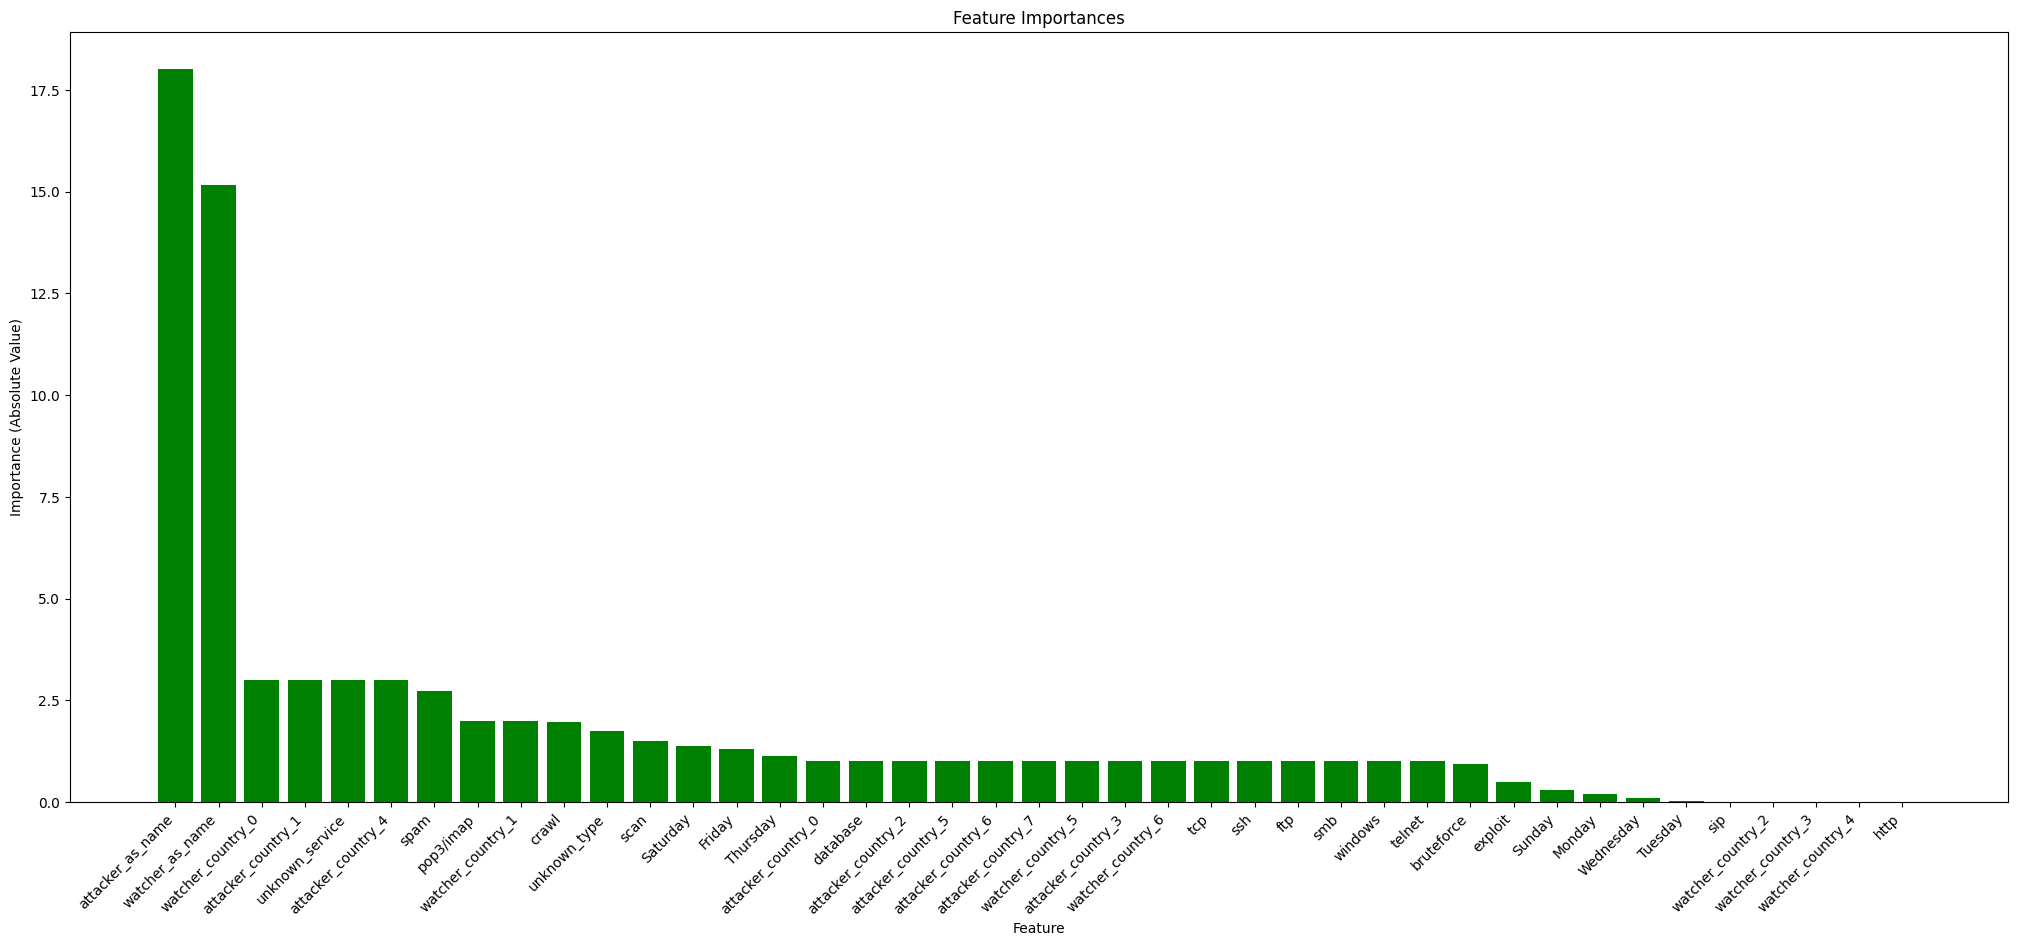

In [ ]:
import matplotlib.pyplot as plt

if hasattr(clf, 'coef_') and isinstance(X_train_enc, pd.DataFrame):
    importances = np.abs(clf.coef_[0])

    feature_names = X_train_enc.columns

    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


    plt.figure(figsize=(25, 10))  # Ajustar el tamaño de la figura
    colors = ['green' if imp > 0 else 'red' for imp in feature_importances['Importance']]
    plt.bar(feature_importances['Feature'], feature_importances['Importance'], color=colors)
    plt.xlabel('Feature')
    plt.ylabel('Importance (Absolute Value)')
    plt.title('Feature Importances')
    plt.xticks(rotation=45, ha='right')

    plt.savefig('feature_importances.png', bbox_inches='tight')

    plt.show()
else:
    print("El modelo no proporciona información sobre la importancia de las características o X_train_enc no es un DataFrame de pandas.")

